# Differentiable Cosmological Simulation with Adjoint Method

In [1]:
import os

# change JAX GPU memory preallocation fraction
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'

import jax
# jax.print_environment_info()

!nvidia-smi --query-gpu=gpu_name --format=csv,noheader

NVIDIA H100 PCIe


In [2]:
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('jpeg')

import jax.numpy as jnp
from IPython.display import YouTubeVideo

from pmwd import (
    Configuration,
    SimpleLCDM,
    boltzmann,
    white_noise, linear_modes,
    lpt,
    nbody,
    scatter,
)
from pmwd.vis_util import simshow

## Reproducibility

GPU can output different results for identical inputs. We compare the particle displacements and velocities between 2 runs,
$\sigma_{\mathbf{s}_1 - \mathbf{s}_2} / \sigma_{\mathbf{s}_1}$ and $\sigma_{\mathbf{p}_1 - \mathbf{p}_2} / \sigma_{\mathbf{p}_1}$.

In [3]:
def check_reproducibility(
        ptcl_spacing,
        mesh_shape,
        a_nbody_maxstep,
        float_dtype,
        ptcl_grid_shape=(384,) * 3,
        seed=0,
    ):
    conf = Configuration(
        ptcl_spacing,
        ptcl_grid_shape,
        mesh_shape=mesh_shape,
        a_nbody_maxstep=a_nbody_maxstep,
        float_dtype=float_dtype,
    )
    cosmo = SimpleLCDM(conf)
    modes = white_noise(seed, conf)

    def model(modes, cosmo, conf):
        cosmo = boltzmann(cosmo, conf)
        modes = linear_modes(modes, cosmo, conf)
        ptcl, obsvbl = lpt(modes, cosmo, conf)
        ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
        return ptcl, obsvbl

    p1, _ = model(modes, cosmo, conf)
    p2, _ = model(modes, cosmo, conf)
    disp_std = p1.disp.std()
    vel_std = p1.vel.std()
    print(f'{float_dtype}, {mesh_shape**3}, {cosmo.ptcl_mass :.0f}, {conf.a_nbody_num :3}'
          f': {(p1.disp - p2.disp).std() / disp_std :.1e}'
          f', {(p1.vel - p2.vel).std() / vel_std :.1e}'
          f'; {disp_std :.1e}, {vel_std :.1e}')

In [4]:
check_reproducibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f4')
check_reproducibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f4')
check_reproducibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f4')
check_reproducibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f4')
check_reproducibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f4')
check_reproducibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f4')
check_reproducibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f4')
check_reproducibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f4')

f4, 8, 1,  63: 1.9e-06, 7.1e-05; 5.1e+00, 3.3e+00
f4, 8, 1, 126: 5.2e-07, 1.3e-05; 5.1e+00, 3.3e+00
f4, 8, 8,  63: 3.1e-07, 2.4e-06; 5.7e+00, 3.5e+00
f4, 8, 8, 126: 3.2e-07, 2.3e-06; 5.7e+00, 3.5e+00
f4, 1, 1,  63: 1.4e-07, 1.5e-06; 5.1e+00, 3.2e+00
f4, 1, 1, 126: 1.3e-07, 1.4e-06; 5.1e+00, 3.2e+00
f4, 1, 8,  63: 1.1e-07, 4.5e-07; 5.6e+00, 3.3e+00
f4, 1, 8, 126: 9.8e-08, 4.4e-07; 5.6e+00, 3.3e+00


| precision | cell/ptcl | ptcl mass $[M_\odot]$ | time steps | disp rel diff | vel rel diff |
| --- | --- | --- | --- | --- | --- |
| single | 8 | 1e10 |  63 | 1.6e-6 | 4.8e-5 |
| single | 8 | 1e10 | 126 | 5.1e-7 | 1.3e-5 |
| single | 8 | 8e10 |  63 | 3.1e-7 | 2.4e-6 |
| single | 8 | 8e10 | 126 | 3.1e-7 | 2.3e-6 |
| single | 1 | 1e10 |  63 | 1.4e-7 | 1.5e-6 |
| single | 1 | 1e10 | 126 | 1.3e-7 | 1.4e-6 |
| single | 1 | 8e10 |  63 | 1.1e-7 | 4.5e-7 |
| single | 1 | 8e10 | 126 | 9.9e-8 | 4.4e-7 |

In [5]:
check_reproducibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f8')
check_reproducibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f8')
check_reproducibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f8')
check_reproducibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f8')
check_reproducibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f8')
check_reproducibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f8')
check_reproducibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f8')
check_reproducibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f8')

f8, 8, 1,  63: 1.2e-15, 3.0e-14; 5.4e+00, 3.5e+00
f8, 8, 1, 126: 7.9e-16, 1.6e-14; 5.4e+00, 3.5e+00
f8, 8, 8,  63: 5.8e-16, 4.2e-15; 5.9e+00, 3.6e+00
f8, 8, 8, 126: 5.9e-16, 4.2e-15; 5.9e+00, 3.6e+00
f8, 1, 1,  63: 2.4e-16, 2.3e-15; 5.4e+00, 3.4e+00
f8, 1, 1, 126: 2.3e-16, 2.3e-15; 5.4e+00, 3.4e+00
f8, 1, 8,  63: 2.0e-16, 7.9e-16; 5.8e+00, 3.4e+00
f8, 1, 8, 126: 1.8e-16, 7.7e-16; 5.9e+00, 3.4e+00


| precision | cell/ptcl | ptcl mass $[M_\odot]$ | time steps | disp rel diff | vel rel diff |
| --- | --- | --- | --- | --- | --- |
| double | 8 | 1e10 |  63 | 1.4e-15 | 3.6e-14 |
| double | 8 | 1e10 | 126 | 8.3e-16 | 1.7e-14 |
| double | 8 | 8e10 |  63 | 5.4e-16 | 4.1e-15 |
| double | 8 | 8e10 | 126 | 5.9e-16 | 4.3e-15 |
| double | 1 | 1e10 |  63 | 2.4e-16 | 2.3e-15 |
| double | 1 | 1e10 | 126 | 2.3e-16 | 2.3e-15 |
| double | 1 | 8e10 |  63 | 1.9e-16 | 7.9e-16 |
| double | 1 | 8e10 | 126 | 1.8e-16 | 7.8e-16 |

## Reversibility

Model differentiation evolves the adjoint equations backward in time. To save memory, trajectory of the model state in the forward run is not saved, but re-simulated together with the adjoint equations. Even though in principle the N-body systems are reversible, in practice the re-simulated trajectory can differ from the forward one due to loss of small-scale information.

We compare the displacements and velocities of particles that have evolved to the final time (a=1) and then back, to those of the LPT initial conditions (a=1/64),
$\sigma_{\mathbf{s}_{rev} - \mathbf{s}_{LPT}} / \sigma_{\mathbf{s}_{LPT}}$ and $\sigma_{\mathbf{p}_{rev} - \mathbf{p}_{LPT}} / \sigma_{\mathbf{p}_{LPT}}$.

In [6]:
def check_reversibility(
        ptcl_spacing,
        mesh_shape,
        a_nbody_maxstep,
        float_dtype,
        ptcl_grid_shape=(384,) * 3,
        seed=0,
    ):
    conf = Configuration(
        ptcl_spacing,
        ptcl_grid_shape,
        mesh_shape=mesh_shape,
        a_nbody_maxstep=a_nbody_maxstep,
        float_dtype=float_dtype,
    )
    cosmo = SimpleLCDM(conf)
    modes = white_noise(seed, conf)

    cosmo = boltzmann(cosmo, conf)
    modes = linear_modes(modes, cosmo, conf)
    p0, obsvbl = lpt(modes, cosmo, conf)

    p1, obsvbl = nbody(p0, obsvbl, cosmo, conf)
    p1, _ = nbody(p1, obsvbl, cosmo, conf, reverse=True)
    disp_std = p0.disp.std()
    vel_std = p0.vel.std()
    print(f'{float_dtype}, {mesh_shape**3}, {cosmo.ptcl_mass :.0f}, {conf.a_nbody_num :3}'
          f': {(p1.disp - p0.disp).std() / disp_std :.1e}'
          f', {(p1.vel - p0.vel).std() / vel_std :.1e}'
          f'; {disp_std :.1e}, {vel_std :.1e}')

In [7]:
check_reversibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f4')
check_reversibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f4')
check_reversibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f4')
check_reversibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f4')
check_reversibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f4')
check_reversibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f4')
check_reversibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f4')
check_reversibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f4')

f4, 8, 1,  63: 4.4e-02, 7.0e-02; 1.0e-01, 6.9e-03
f4, 8, 1, 126: 2.2e-02, 3.7e-02; 1.0e-01, 6.9e-03
f4, 8, 8,  63: 3.4e-03, 7.8e-03; 1.1e-01, 7.7e-03
f4, 8, 8, 126: 3.6e-03, 6.9e-03; 1.1e-01, 7.7e-03
f4, 1, 1,  63: 1.4e-03, 2.2e-03; 1.0e-01, 6.9e-03
f4, 1, 1, 126: 1.3e-03, 1.7e-03; 1.0e-01, 6.9e-03
f4, 1, 8,  63: 4.5e-04, 7.7e-04; 1.1e-01, 7.7e-03
f4, 1, 8, 126: 4.1e-04, 5.8e-04; 1.1e-01, 7.7e-03


| precision | cell/ptcl | ptcl mass $[M_\odot]$ | time steps | disp rel diff | vel rel diff |
| --- | --- | --- | --- | --- | --- |
| single | 8 | 1e10 |  63 | 5.2e-2 | 7.1e-2 |
| single | 8 | 1e10 | 126 | 2.1e-2 | 3.6e-2 |
| single | 8 | 8e10 |  63 | 3.3e-3 | 7.6e-3 |
| single | 8 | 8e10 | 126 | 3.7e-3 | 7.0e-3 |
| single | 1 | 1e10 |  63 | 1.4e-3 | 2.2e-3 |
| single | 1 | 1e10 | 126 | 1.3e-3 | 1.7e-3 |
| single | 1 | 8e10 |  63 | 4.3e-4 | 7.3e-4 |
| single | 1 | 8e10 | 126 | 4.4e-4 | 6.3e-4 |

In [8]:
check_reversibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f8')
check_reversibility(ptcl_spacing=.5, mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f8')
check_reversibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/64, float_dtype='f8')
check_reversibility(ptcl_spacing=1., mesh_shape=2, a_nbody_maxstep=1/128, float_dtype='f8')
check_reversibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f8')
check_reversibility(ptcl_spacing=.5, mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f8')
check_reversibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/64, float_dtype='f8')
check_reversibility(ptcl_spacing=1., mesh_shape=1, a_nbody_maxstep=1/128, float_dtype='f8')

f8, 8, 1,  63: 6.0e-11, 1.5e-10; 1.1e-01, 7.4e-03
f8, 8, 1, 126: 3.6e-11, 6.9e-11; 1.1e-01, 7.4e-03
f8, 8, 8,  63: 5.8e-12, 1.4e-11; 1.2e-01, 8.0e-03
f8, 8, 8, 126: 6.5e-12, 1.2e-11; 1.2e-01, 8.0e-03
f8, 1, 1,  63: 2.2e-12, 3.5e-12; 1.1e-01, 7.4e-03
f8, 1, 1, 126: 2.1e-12, 2.8e-12; 1.1e-01, 7.4e-03
f8, 1, 8,  63: 7.0e-13, 1.2e-12; 1.2e-01, 8.0e-03
f8, 1, 8, 126: 7.1e-13, 9.9e-13; 1.2e-01, 8.0e-03


| precision | cell/ptcl | ptcl mass $[M_\odot]$ | time steps | disp rel diff | vel rel diff |
| --- | --- | --- | --- | --- | --- |
| double | 8 | 1e10 |  63 | 5.4e-11 | 1.3e-10 |
| double | 8 | 1e10 | 126 | 3.5e-11 | 7.0e-11 |
| double | 8 | 8e10 |  63 | 5.8e-12 | 1.4e-11 |
| double | 8 | 8e10 | 126 | 6.4e-12 | 1.2e-11 |
| double | 1 | 1e10 |  63 | 2.2e-12 | 3.4e-12 |
| double | 1 | 1e10 | 126 | 2.1e-12 | 2.9e-12 |
| double | 1 | 8e10 |  63 | 7.2e-13 | 1.2e-12 |
| double | 1 | 8e10 | 126 | 6.9e-13 | 9.4e-13 |

## A toy problem

16×27×16=6912 particles, in a 160 × 270 × 160 Mpc$^3/h^3$ box, evolving with a 2× mesh (32×54×32) from $a=1/64$ to $a=1$ to match the 2D projection to the target image below at 4× resolution (64×108).

In [9]:
from PIL import Image, ImageFont, ImageDraw


text = 'pmwd'
font = ImageFont.truetype('../nova/NovaRoundSlim-BookOblique.ttf', 32)

ptcl_spacing = 10.
ptcl_grid_shape = (16, 27, 16)
mesh_shape = (32, 54, 32)
im_shape = (64, 108)
xy = (52, 28)

im = Image.new('L', im_shape[::-1], 255)
draw = ImageDraw.Draw(im)
draw.text(xy, text, font=font, anchor='mm')

# normalize the image to make the target
im_tgt = 1 - jnp.asarray(im) / 255
im_tgt *= jnp.prod(jnp.array(ptcl_grid_shape)) / im_tgt.sum()

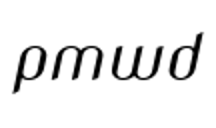

In [10]:
im.resize((216, 128))

In [11]:
from functools import partial

from jax.example_libraries.optimizers import adam


def model(modes, cosmo, conf):
    modes = linear_modes(modes, cosmo, conf)
    ptcl, obsvbl = lpt(modes, cosmo, conf)
    ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
    dens = scatter_2d(ptcl, conf)
    return dens

def scatter_2d(ptcl, conf):
    dens = jnp.zeros(tuple(2*s for s in conf.mesh_shape), dtype=conf.float_dtype)
    dens = scatter(ptcl, conf, mesh=dens, val=1, cell_size=conf.cell_size / 2)
    return dens.sum(axis=2)

pmwdshow = partial(simshow, figsize=(27/4, 4), cmap='cividis', colorbar=False)

def obj(tgt, modes, cosmo, conf):
    dens = model(modes, cosmo, conf)
    return (dens - tgt).var() / tgt.var()

obj_valgrad = jax.value_and_grad(obj, argnums=1)

# def optim(tgt, modes, cosmo, conf, iters=100, lr=1e-3):
#     tgt = jnp.asarray(tgt)
#     for i in range(iters):
#         value, modes_grad = obj_valgrad(tgt, modes, cosmo, conf)
#         modes = modes - lr * modes_grad.conj()
#     return value, modes

def optim(tgt, modes, cosmo, conf, iters=100, lr=0.1):
    init, update, get_params = adam(lr)
    state = init(modes)

    def step(i, state, tgt, cosmo, conf):
        modes = get_params(state)
        value, grads = obj_valgrad(tgt, modes, cosmo, conf)
        state = update(i, grads, state)
        return value, state

    tgt = jnp.asarray(tgt)
    for i in range(iters):
        value, state = step(i, state, tgt, cosmo, conf)

    modes = get_params(state)
    return value, modes

In [12]:
conf = Configuration(ptcl_spacing, ptcl_grid_shape, mesh_shape)
cosmo = SimpleLCDM(conf)
seed = 0
modes = white_noise(seed, conf, real=True)
cosmo = boltzmann(cosmo, conf)

LPT ICs at a=1/64.

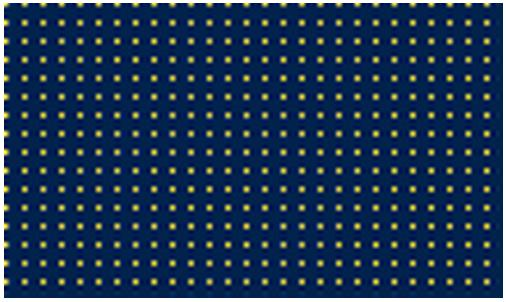

In [13]:
ptcl, obsvbl = lpt(linear_modes(modes, cosmo, conf), cosmo, conf)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

Time integration for 63 steps to a=1.

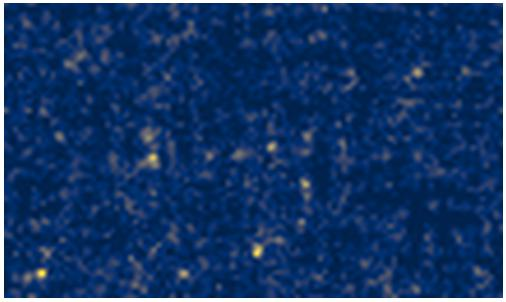

In [14]:
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

Reverse the arrow of time and integrate backward to a=1/64.

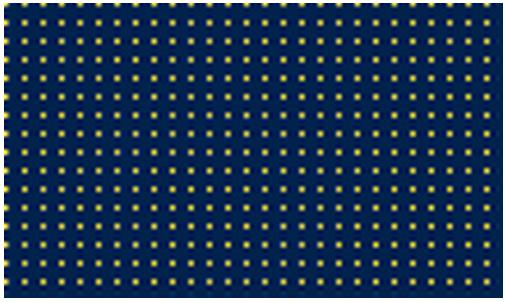

In [15]:
ptcl, obsvbl = nbody(ptcl, obsvbl, cosmo, conf, reverse=True)
fig, ax = pmwdshow(scatter_2d(ptcl, conf))

Here's a [YouTube video](https://www.youtube.com/watch?v=Epsgh6vr0qs) for this forward and then reverse time integration.

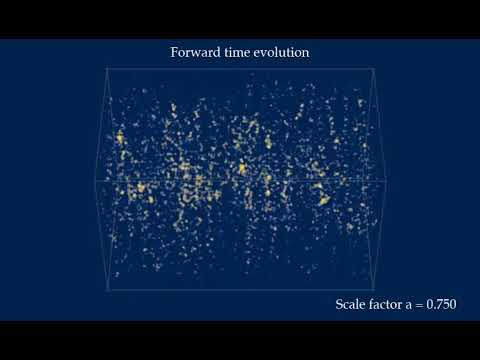

In [16]:
YouTubeVideo('Epsgh6vr0qs', width=648, height=384, allow_autoplay=True)

After 1 iteration:

In [17]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=1)
loss, modes.std(), modes_optim.std()

(Array(1.127, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.006, dtype=float32))

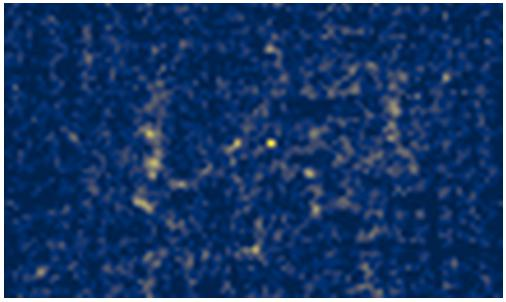

In [18]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

Optimize for an interesting objective at a=1. After 10 iteration:

In [19]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=10)
loss, modes.std(), modes_optim.std()

(Array(0.793, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.027, dtype=float32))

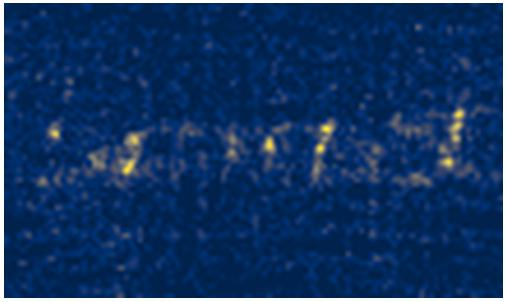

In [20]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

After 30 iteration:

In [21]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=30)
loss, modes.std(), modes_optim.std()

(Array(0.49, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.076, dtype=float32))

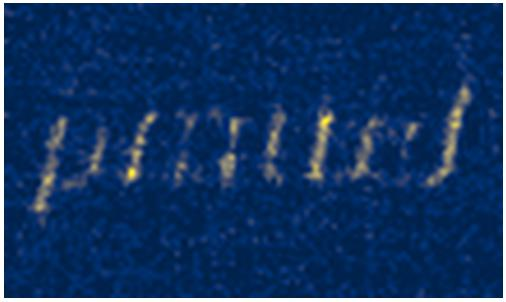

In [22]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

After 100 iteration:

In [23]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=100)
loss, modes.std(), modes_optim.std()

(Array(0.361, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.115, dtype=float32))

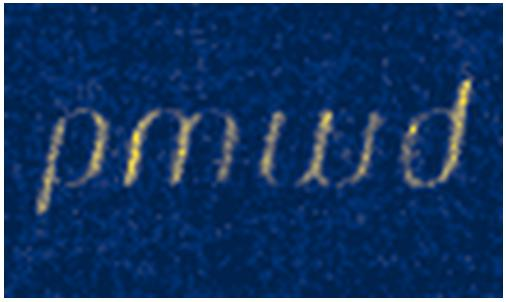

In [24]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

After 300 iteration:

In [25]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=300)
loss, modes.std(), modes_optim.std()

(Array(0.24, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.165, dtype=float32))

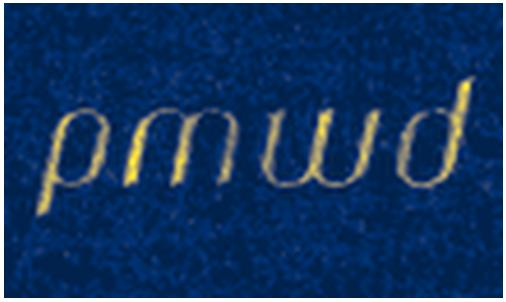

In [26]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

After 1000 iteration:

In [27]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=1000)
loss, modes.std(), modes_optim.std()

(Array(0.264, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.223, dtype=float32))

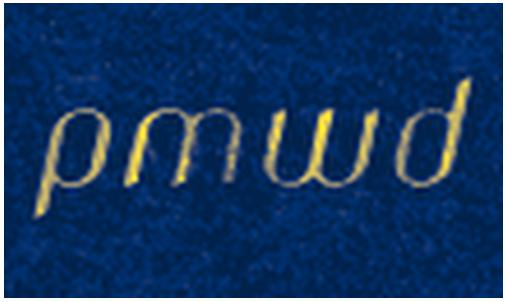

In [28]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

After 3000 iteration:

In [29]:
loss, modes_optim = optim(im_tgt, modes, cosmo, conf, iters=3000)
loss, modes.std(), modes_optim.std()

(Array(0.196, dtype=float32),
 Array(1.004, dtype=float32),
 Array(1.366, dtype=float32))

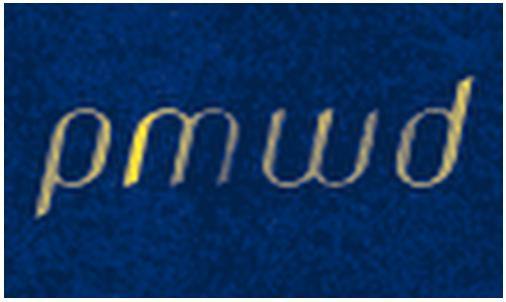

In [30]:
fig, ax = pmwdshow(model(modes_optim, cosmo, conf))

Here's a [YouTube video](https://www.youtube.com/watch?v=vD6lbjHP3SY) for a similar optimization process, in which we want to match not just one but two perpendicular 2D projections to the same target image.

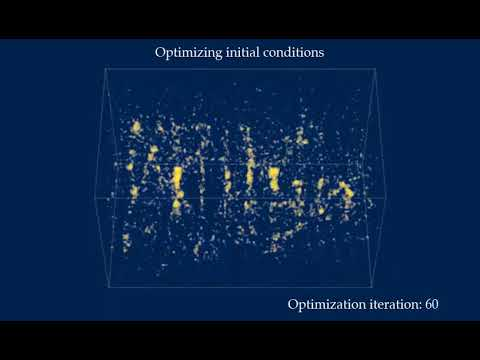

In [31]:
YouTubeVideo('vD6lbjHP3SY', width=648, height=384, allow_autoplay=True)